# NLP Workshop Part-1
### Text as Data

---

Text is an extremely rich source for data. Tapping into it can yield great insights, but creating a pipeline from raw data to metrics and visualizations often feels like it requires more grit and luck than anything else.

In this first workshop we'll take a high-level look at some of the fundamentals of Natural Language Processing, or NLP, from cleaning data to extracting insights.

---

**Contents:**
* Cleaning/Preprocessing Text (80 - 95%)
    - tokenization, removal (punctuation, stopwords), stemming/lemmatization
* Analyzing Text (5 - 20%)
    - word clouds, tfidf, clustering

---

# Phase 1: initial approach

In [1]:
# If you haven't wokred with nltk, un-comment and run the lines below

# !pip install wordcloud
# !pip install nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data storage
import pickle

# elemental libraries for text data
import string
import re
from collections import Counter

# fancy NLP libraries
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# clustering imports
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# visuals
from wordcloud import WordCloud

In [3]:
# this is copy paste from a google search of making a wordcloud

def make_cloud(freq_dict):
    '''make a wordcloud from a word frequency dictionary'''
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freq_dict)

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [4]:
# reading in pickled data

job_text = pickle.load(open('job_descriptions.pkl', 'rb'))
len(job_text)

349

In [5]:
# first job description

example_text = job_text[0]

print(example_text)

Overview
Intuit is seeking a Senior Manager to join the Consumer Tax Group in San Diego, CA.


The Consumer tax group develops game changing experiences, technologies and experiments that redefine and disrupt our current product offerings. You’ll be leading team of data scientists designing, building, iterating, and prototyping algorithms and applications on top of the collective financial data of 37 million consumers and small businesses. Applications will span multiple business lines, including personal finance, small business accounting, and tax.
Responsibilities
Lead and create a team of data scientists
Mentor and hire the best data scientists in the valley
Applies artificial intelligence and machine learning techniques to solve complex questions or fuel new business opportunities
Delivers breakthrough benefits to Intuit users/customers across small business & consumer products using individual, enriched, and aggregated data
Provides leadership in advanced engineering, data science

# Tokenization

Tokens are the elemental - or indivisible - pieces of a text document. We can break text into words, n-grams, and sentences.

In [6]:
# tokens generated from single words

tokens = word_tokenize(example_text)
tokens[:10]

['Overview',
 'Intuit',
 'is',
 'seeking',
 'a',
 'Senior',
 'Manager',
 'to',
 'join',
 'the']

In [7]:
# using Counter to count words

Counter(tokens).most_common(10)

[(',', 39),
 ('and', 33),
 ('to', 14),
 ('.', 14),
 ('the', 13),
 ('of', 13),
 ('data', 12),
 ('a', 9),
 ('in', 9),
 ('that', 6)]

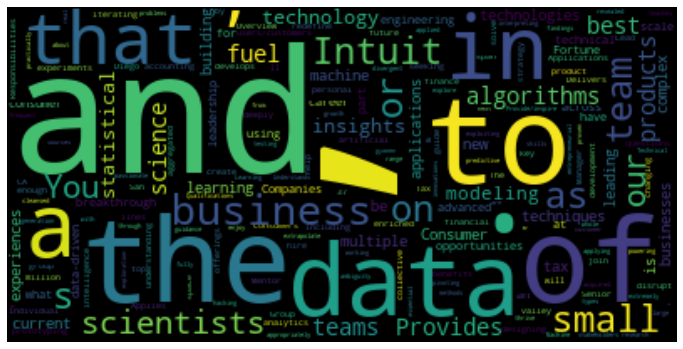

In [8]:
# take a look

make_cloud(Counter(tokens))

In [9]:
# using "tokens" we can call ngrams to get chunks of words as tokens

list(ngrams(tokens[:20], 2))

[('Overview', 'Intuit'),
 ('Intuit', 'is'),
 ('is', 'seeking'),
 ('seeking', 'a'),
 ('a', 'Senior'),
 ('Senior', 'Manager'),
 ('Manager', 'to'),
 ('to', 'join'),
 ('join', 'the'),
 ('the', 'Consumer'),
 ('Consumer', 'Tax'),
 ('Tax', 'Group'),
 ('Group', 'in'),
 ('in', 'San'),
 ('San', 'Diego'),
 ('Diego', ','),
 (',', 'CA'),
 ('CA', '.'),
 ('.', 'The')]

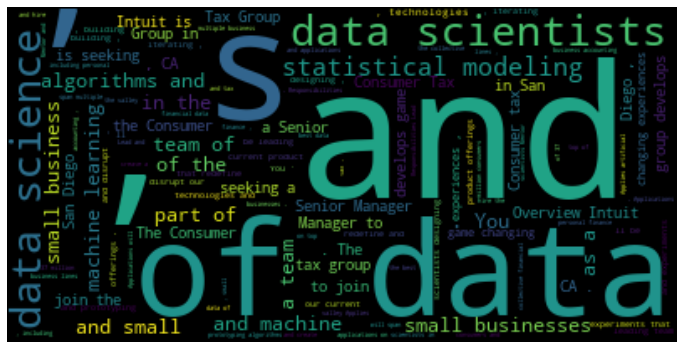

In [10]:
# combining the words within each token, and calling wordcloud

bigrams = [' '.join(gram) for gram in ngrams(tokens, 2)]

make_cloud(Counter(bigrams))

In [11]:
bigrams[:10]

['Overview Intuit',
 'Intuit is',
 'is seeking',
 'seeking a',
 'a Senior',
 'Senior Manager',
 'Manager to',
 'to join',
 'join the',
 'the Consumer']

In [12]:
# tokenizing sentences is tricky

sent_tokenize(example_text)[:3]

['Overview\nIntuit is seeking a Senior Manager to join the Consumer Tax Group in San Diego, CA.',
 'The Consumer tax group develops game changing experiences, technologies and experiments that redefine and disrupt our current product offerings.',
 'You’ll be leading team of data scientists designing, building, iterating, and prototyping algorithms and applications on top of the collective financial data of 37 million consumers and small businesses.']

---
# Phase 2: Cleaning Up

Know how to clean your data.

# Cleaning Up - identifying and removing stuff

Something something, data science is art. This step will always be subject to your data, your business problem, and politics. 

"Knowing what you can and can't do makes you a great analyst, knowing what you should and shouldn't do makes you the manager of analysts."

-Dr. Hugh Watson, probably

In [13]:
# check every character in our document

unique_characters = {i for i in example_text}
unique_characters

{'\n',
 ' ',
 '!',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '7',
 ':',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'I',
 'L',
 'M',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '’',
 '“',
 '”'}

In [14]:
# characters in string.punctuation

string.punctuation + string.digits

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [15]:
# removing everything but letters
# also, moving to lower-case only

letters = {i.lower() for i in unique_characters if i not in string.punctuation + string.digits}
letters

{'\n',
 ' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '’',
 '“',
 '”'}

In [16]:
# grabbing all the non-letters

really_only_letters = {i for i in letters if i not in ['\n', '’', '“', '”']}
really_only_letters  # and spaces, because a blob of text without spaces would be even worse

{' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [17]:
# bringing it all together, let's make our text into only text

non_char = string.punctuation + string.digits + '\n' + '’' + '“' + '”'

cleaner_text = re.sub('[%s]' % re.escape(non_char), ' ', example_text.lower())
cleaner_text

'overview intuit is seeking a senior manager to join the consumer tax group in san diego  ca    the consumer tax group develops game changing experiences  technologies and experiments that redefine and disrupt our current product offerings  you ll be leading team of data scientists designing  building  iterating  and prototyping algorithms and applications on top of the collective financial data of    million consumers and small businesses  applications will span multiple business lines  including personal finance  small business accounting  and tax  responsibilities lead and create a team of data scientists mentor and hire the best data scientists in the valley applies artificial intelligence and machine learning techniques to solve complex questions or fuel new business opportunities delivers breakthrough benefits to intuit users customers across small business   consumer products using individual  enriched  and aggregated data provides leadership in advanced engineering  data scienc

# Cleaning Up - stop words

Stop words: common words like "and, this, that" which have little to no value for semantic analysis.

Removing stop words removes noise, enhancing relevant information

"The dog ran really fast." -> "dog ran fast"

In [18]:
# some stop words

sorted(stopwords.words('english'))

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [19]:
# simply remove the stopwords
# note: using split() and join together also removes extra spaces

even_cleaner_text = ' '.join([i for i in cleaner_text.split() 
                              if i not in stopwords.words('english')])
even_cleaner_text

'overview intuit seeking senior manager join consumer tax group san diego ca consumer tax group develops game changing experiences technologies experiments redefine disrupt current product offerings leading team data scientists designing building iterating prototyping algorithms applications top collective financial data million consumers small businesses applications span multiple business lines including personal finance small business accounting tax responsibilities lead create team data scientists mentor hire best data scientists valley applies artificial intelligence machine learning techniques solve complex questions fuel new business opportunities delivers breakthrough benefits intuit users customers across small business consumer products using individual enriched aggregated data provides leadership advanced engineering data science analytics development current future products technologies provides technical leadership across multiple teams understanding key technology space d

# Cleaning Up - stemming and lemmatization

Stemming: reducing words to base form

Lemmatization: stemming + crazy linguistics stuff

Essentially, the goal here is to make our lexicon significantly smaller - i.e. reduce complexity.

In [20]:
# quick example

stemmer = PorterStemmer()  # stemming class
lemmer = WordNetLemmatizer()  # lemmatization class

same_things = ['ran', 'run', 'runs', 'running', 'runner', 'runners']

for i in same_things:
    print('Stem - {}  ;  Lemma - {}'.format(stemmer.stem(i), lemmer.lemmatize(i)))

Stem - ran  ;  Lemma - ran
Stem - run  ;  Lemma - run
Stem - run  ;  Lemma - run
Stem - run  ;  Lemma - running
Stem - runner  ;  Lemma - runner
Stem - runner  ;  Lemma - runner


In [21]:
# squeaky clean

cleanest_text = ' '.join([lemmer.lemmatize(i) for i in even_cleaner_text.split()])
cleanest_text

'overview intuit seeking senior manager join consumer tax group san diego ca consumer tax group develops game changing experience technology experiment redefine disrupt current product offering leading team data scientist designing building iterating prototyping algorithm application top collective financial data million consumer small business application span multiple business line including personal finance small business accounting tax responsibility lead create team data scientist mentor hire best data scientist valley applies artificial intelligence machine learning technique solve complex question fuel new business opportunity delivers breakthrough benefit intuit user customer across small business consumer product using individual enriched aggregated data provides leadership advanced engineering data science analytics development current future product technology provides technical leadership across multiple team understanding key technology space deeply enough help guide strat

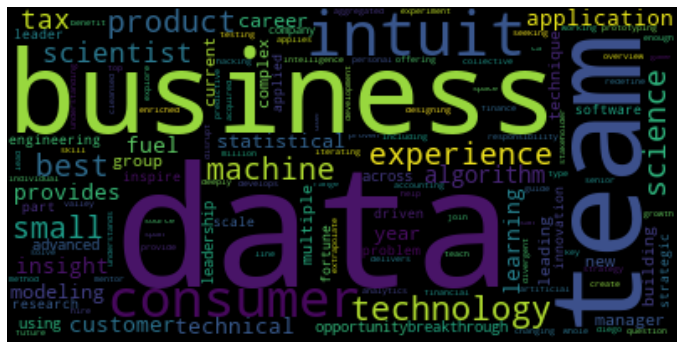

In [22]:
# time for another cloud

tokens = word_tokenize(cleanest_text)
bigrams = [' '.join(gram) for gram in ngrams(tokens, 2)]

make_cloud(Counter(tokens))

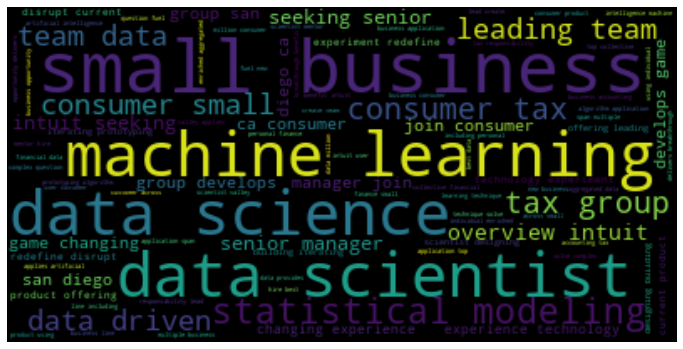

In [23]:
make_cloud(Counter(bigrams))

In [24]:
# compiling all of the prior stuff into a function

def clean(text):
    '''
    given some text, clean it
    import string
    import re
    from nltk.corpus import stopwords
    from nltk import WordNetLemmatizer
    '''
    # remove stuff
    non_char = string.punctuation + string.digits + '\n' + '’' + '“' + '”'
    cleaner_text = re.sub('[%s]' % re.escape(non_char), ' ', text.lower())
    # import lemma
    lemma = WordNetLemmatizer()
    # combine lemma and stopword removal
    clean_text = ' '.join([lemma.lemmatize(i) for i in cleaner_text.split() 
                           if i not in stopwords.words('english')])
    
    return clean_text


# clean all text

clean_jobs = [clean(i) for i in job_text]

---
# Phase 3: Analysis

# Analysis - CountVectorizer

It's easy enough to apply the above to all of our text with a function, but we need some way to manipulate it all as data. Counter is sufficient for one document, CountVectorizer is sufficient for many.

In [25]:
# spin up CountVectorizer and test it out on the cleanest text

cv = CountVectorizer()

X = cv.fit_transform([cleanest_text])
pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

,aa,ability,able,accounting,acquired,across,action,admired,advanced,aggregated,...,vector,vet,vision,whole,winning,work,working,world,worldwide,year
0,1,1,1,1,1,2,1,1,2,1,...,1,1,1,1,1,1,1,1,1,3


In [26]:
# CV has ngrams builtin

cv = CountVectorizer(ngram_range=(2, 2))

X = cv.fit_transform([cleanest_text])
pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

,aa vet,ability convert,able effectively,accounting tax,acquired cleansed,across multiple,across small,action plan,admired software,advanced engineering,...,vision inspire,whole understands,winning culture,work fortune,working divergent,world admired,worldwide discover,year experience,year intuit,year year
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [27]:
# now run it on everything

cv = CountVectorizer(min_df=0.1, max_df=0.9)

X = cv.fit_transform(clean_jobs)
counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
counts

,ability,able,access,accommodation,accuracy,achieve,across,action,activity,additional,...,within,without,word,work,working,world,writing,written,www,year
0,1,1,0,0,0,0,2,1,0,0,...,0,0,0,1,1,1,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,2,1,1,1,1,0,2,0,0,1
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1,0,0,0,0,0,2,0,0,0,...,1,2,0,6,0,0,0,0,0,2
345,0,0,0,0,0,0,0,0,0,0,...,0,1,0,4,1,0,0,0,0,2
346,11,0,0,0,0,0,1,0,0,0,...,0,0,1,2,0,0,0,1,0,1
347,1,0,1,0,0,0,2,0,0,0,...,0,0,0,2,0,0,0,1,0,4


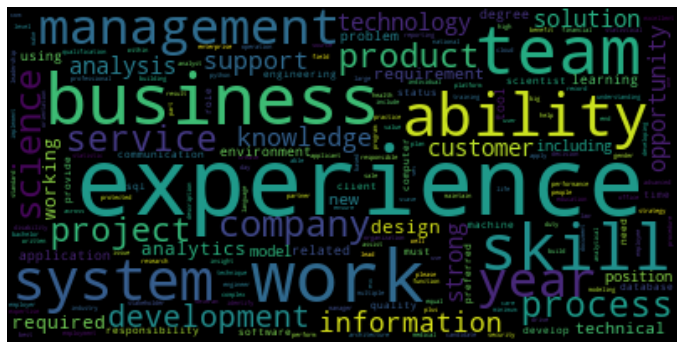

In [28]:
make_cloud(counts.sum(axis=0))

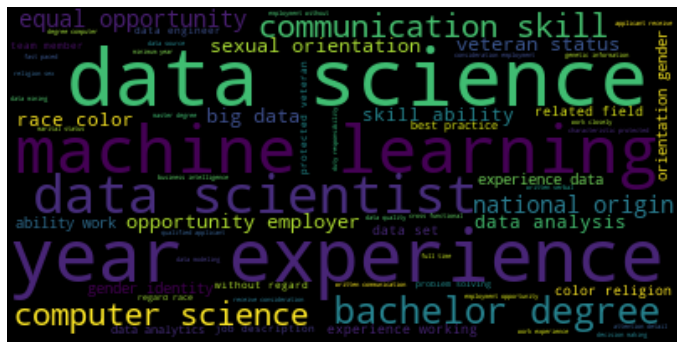

In [29]:
cv = CountVectorizer(ngram_range=(2, 2), min_df=0.1, max_df=0.9)

X = cv.fit_transform(clean_jobs)
bigram_counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

make_cloud(bigram_counts.sum(axis=0))

# Analysis - TFIDF

Counts are a good source of information, but Term Frequency Inverse Document Frequency gives a weight representation of word importances.

In [30]:
# straight to the df

tf = TfidfVectorizer(ngram_range=(1, 3), min_df=0.1, max_df=0.9,
                     stop_words=['experience'])

X = tf.fit_transform(clean_jobs)
scores = pd.DataFrame(X.toarray(), columns=tf.get_feature_names())
scores

,ability,ability work,able,access,accommodation,accuracy,achieve,across,action,activity,...,work closely,working,world,writing,written,written communication,written communication skill,written verbal,www,year
0,0.030949,0.000000,0.053331,0.000000,0.0,0.0,0.0,0.090974,0.060952,0.0,...,0.000000,0.033541,0.054832,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.081656
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,0.025852,0.000000,0.089097,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.028017,0.000000,0.109666,0.000000,0.0,0.0,0.000000,0.000000,0.022736
3,0.000000,0.000000,0.088026,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.144135,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.120486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0.024418,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.071775,0.000000,0.0,...,0.051379,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.042949
345,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.042081,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.068299
346,0.300958,0.047930,0.000000,0.000000,0.0,0.0,0.0,0.040212,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.039359,0.0,0.0,0.000000,0.000000,0.024062
347,0.029791,0.000000,0.000000,0.057495,0.0,0.0,0.0,0.087569,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.042856,0.0,0.0,0.061254,0.000000,0.104799


In [31]:
# reduce feature-space and cluster

pca = PCA(n_components=3)
pca.fit(scores)
pca_scores = pca.transform(scores)

k = 4
km = KMeans(n_clusters=k, random_state=42)
km.fit(pca_scores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [32]:
# cluster labels

km.labels_

array([3, 1, 2, 2, 3, 2, 3, 3, 2, 0, 0, 3, 1, 0, 0, 1, 3, 3, 2, 3, 1, 2,
       2, 3, 0, 0, 2, 1, 2, 3, 0, 3, 1, 3, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0,
       1, 2, 1, 1, 0, 2, 1, 2, 3, 1, 0, 3, 2, 3, 0, 1, 3, 3, 2, 3, 3, 0,
       1, 1, 3, 3, 0, 2, 0, 3, 2, 3, 0, 0, 2, 3, 0, 3, 1, 3, 0, 3, 1, 2,
       2, 2, 3, 0, 3, 2, 1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 3, 3, 2, 3,
       1, 1, 0, 3, 0, 1, 2, 2, 1, 2, 2, 2, 3, 0, 0, 1, 2, 0, 3, 3, 2, 1,
       1, 0, 1, 0, 3, 0, 0, 2, 2, 1, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3,
       0, 0, 1, 3, 3, 3, 0, 1, 0, 1, 0, 1, 2, 3, 3, 3, 3, 1, 3, 2, 0, 0,
       2, 1, 0, 1, 2, 2, 3, 0, 0, 3, 3, 3, 3, 0, 1, 2, 0, 2, 0, 0, 3, 3,
       3, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 3, 1, 2, 3, 1, 1, 2, 1, 2, 0, 1,
       3, 0, 3, 0, 2, 3, 2, 2, 2, 0, 3, 2, 3, 3, 1, 2, 3, 1, 2, 0, 1, 0,
       2, 3, 0, 1, 3, 3, 0, 0, 0, 0, 3, 0, 1, 3, 3, 2, 3, 3, 2, 1, 2, 3,
       0, 3, 1, 3, 1, 1, 2, 1, 0, 0, 0, 3, 2, 0, 3, 1, 1, 3, 0, 0, 1, 2,
       0, 1, 2, 0, 1, 3, 3, 1, 3, 3, 0, 1, 1, 2, 3,

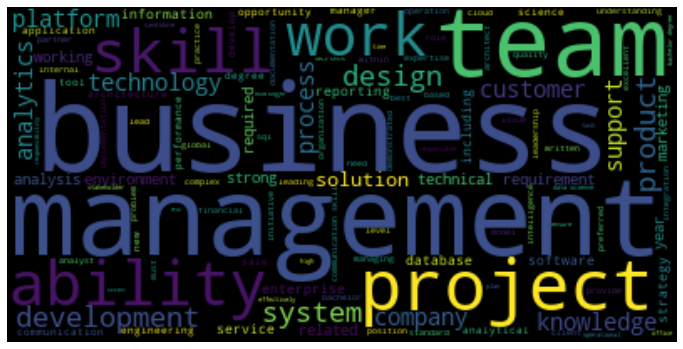

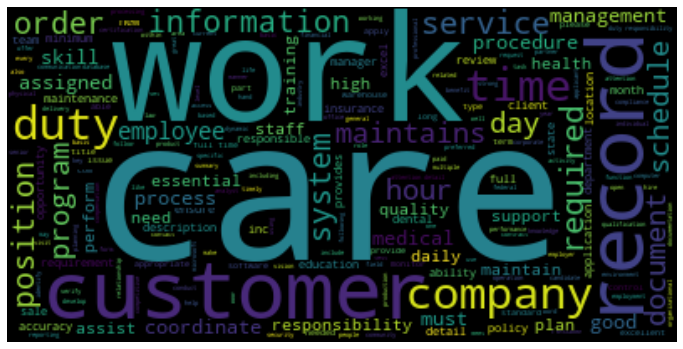

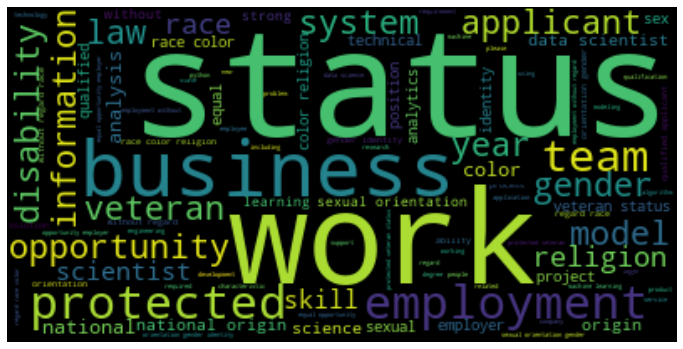

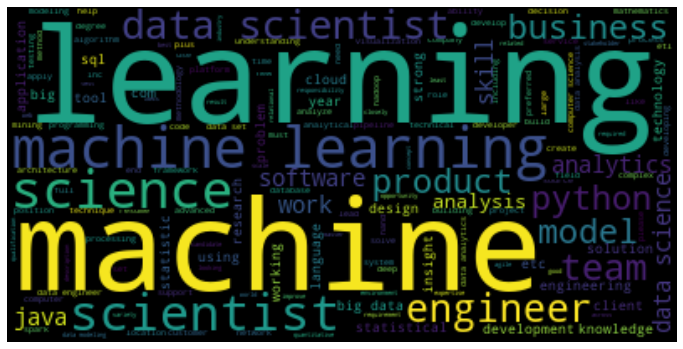

In [33]:
# clouds of clusters

scores['cluster_label'] = km.labels_

for i in range(k):
    cluster = scores[scores['cluster_label'] == i].iloc[:,:-1]
    make_cloud(cluster.sum(axis=0))